# Analyzing Healthcare Insurance Data Stored in an Online MySQL Database

## Project Overview

This Jupyter Notebook uses healthcare insurance data stored in a MySQL database hosted by ClearDB and Heroku to conduct time series analysis.  The insurance data is from a real insurance company based in Pennsylvania.  **FIXME: data cleared by supervisor, etc.**  The data contains member and provider information, as well as dated claims from January 1st, 2015 to December 31st 2021.

Additional information and documentation can be found on this project Github [here](https://github.com/zachcarlson/InsuranceDatabase).

## Team Members:

Alphabetized by last name:

- Zach Carlson, zc378@drexel.edu 
- Katy Matulay, km3868@drexel.edu
- Jacob Stank, js4977@drexel.edu
- Jacob Williamson, jjw324@drexel.edu

## Assumptions:

This notebook makes several assumptions about configuration.  Please ensure you satisfy these before running the Notebook:
1. You are opening this notebook in **Jupyter Notebook**.
2. You have access to a properly configured local or online database.
2. **You are using Windows.**  (We will include steps for Mac configuration in a separate `.ipynb`)
3. You have created a `database_info.py` Python file that contains the connection string to your local/online database.
4. The database you are using is compatible with [SQLAlchemy](https://docs.sqlalchemy.org/en/14/core/engines.html) (e.g. PostgreSQL, MySQL, Oracle, Microsoft SQL Server, etc.)

## Useful Tutorials:

- MySQL+Heroku configuration:
    - [FIXME Windows]()
    - [FIXME Mac]()
- Local MySQL configuration:
    - [FIXME Windows]()
    - [FIXME Mac]()
- Oracle configuraiton:
    - [FIXME Windows]()
    - [FIXME Mac]()

## Configuration:
### Install Packages:

Ensure you have the library `sqlalchemy` installed in order to connect to the MySQL database.  Install these packages by uncommenting the code cell below:

In [1]:
# !pip install sqlalchemy

In [63]:
!pip install statsmodels

     ---------------------------------------- 9.1/9.1 MB 20.9 MB/s eta 0:00:00
     ---------------------------------------- 233.7/233.7 KB ? eta 0:00:00


### Load Functions and Packages:

In [64]:
import database_info #personal .py file containing database login info
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
from sklearn.metrics import mean_squared_error
from sqlalchemy import create_engine
import warnings

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
def import_data_from_database(table_name, engine):
    '''
    PURPOSE: Read in entire table from database to a pandas df

    PARAMETERS:
    -----------
        table_name : str
            Name of table in database
        engine : Engine object
            MySQL connection engine built using sqlalchemy.create_engine
    '''
    sql_query = "SELECT * FROM " + table_name
    df = pd.read_sql(sql_query, engine)
    return df

In [44]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

### Connect to SQL Database:

Now we can make our SQL connnection, first load in your `database_info.py` file:

In [4]:
import database_info

Now let's create our connection engine.  Make sure you've updated `database_info.py` with your connection information as well as ensuring the port number is correct:

In [5]:
from sqlalchemy import create_engine
engine = create_engine(database_info.connection_string)

## Import SQL tables using `pandas`:

The tables stored in our database are:
- `claim_fact`
- `dim_date`
- `dim_member`
- `dim_member_condition`
- `dim_place_of_service`
- `dim_procedure`
- `dim_provider`
- `dim_provider_specialty`
- `dim_reporting_category`

In [6]:
#read in tables from database
claims = import_data_from_database("claim_fact", engine)
members = import_data_from_database("dim_member", engine)
member_conditions = import_data_from_database("dim_member_condition", engine)
place_of_service = import_data_from_database("dim_place_of_service", engine)
procedure = import_data_from_database("dim_procedure", engine)
providers = import_data_from_database("dim_provider", engine)
provider_specialties = import_data_from_database("dim_provider_specialty", engine)
provider_categories = import_data_from_database("dim_reporting_category", engine)

In [7]:
claims.head()

,IDNO,ClaimID,ClaimLineNum,ClaimStatusCd,ClaimType,MemberID,ProviderID,posID,ServiceDate,LoadDate,Code_Type,Code_Value,Cases,Services,AllowedCharges,PaidClaims,MemberPaid,OPL
0,1,1,1,A,P,102,1664,5,2015-01-02,2015-02-28,HCPC,98941,1.0,1.0,28.0,0.0,28.0,0.0
1,2,1,2,A,P,102,1664,5,2015-01-02,2015-02-28,HCPC,97110,1.0,1.0,21.6,0.0,21.6,0.0
2,3,1,3,A,P,102,1664,5,2015-01-02,2015-02-28,HCPC,97012,0.0,1.0,12.0,0.0,12.0,0.0
3,4,1,4,A,P,102,1664,5,2015-01-02,2015-02-28,HCPC,97014,0.0,1.0,12.0,0.0,12.0,0.0
4,5,2,1,A,P,102,1664,5,2015-01-23,2015-03-14,HCPC,98941,1.0,1.0,28.0,0.0,28.0,0.0


In [8]:
members.head()

,IDNO,memberID,Gender,dateOfBirth,firstname,lastname,address_street,address_city,address_County,address_state,address_zip,Product,Client_ID,StartDate,EndDate
0,1,1,F,1995-02-24,Olivia,Donald,691 Arkansas Pine Street,Bairdford,Allegheny,PA,15006,HMO,A00123,2015-05-01,2017-12-31
1,2,2,F,1966-10-17,Emma,Dunn,2949 Arkansas Soft Pine Street,Bakerstown,Allegheny,PA,15007,HMO,A00123,2016-11-01,2017-03-31
2,3,3,M,1965-09-28,Liam,Aaron,1060 Blackjack Pine Street,Bulk Mail Center,Allegheny,PA,15095,HMO,A00123,2016-11-01,2017-03-31
3,4,4,M,1995-03-15,Noah,Archer,2383 Blister Fir Street,Warrendale,Allegheny,PA,15095,HMO,A00123,2016-11-01,2017-03-31
4,5,5,M,1987-06-04,Noah,Archer,2383 Blister Fir Street,Warrendale,Allegheny,PA,15095,HMO,A00123,2016-10-01,2017-06-30


In [9]:
member_conditions.head()

,IDNO,memberID,DIABETES,CAD,CHF,HYPERTENSION,COPD,StartDate,EndDate
0,1,1,0,0,0,0,0,2015-05-01,2017-12-31
1,2,2,0,0,0,0,0,2016-11-01,2017-03-31
2,3,3,0,0,0,0,0,2016-11-01,2017-03-31
3,4,4,0,0,0,0,0,2016-11-01,2017-03-31
4,5,5,0,0,0,0,0,2016-10-01,2017-06-30


In [10]:
place_of_service.head()

,posID,pos_Desc,pos_category
0,1,Pharmacy,OF
1,2,Telehealth,OF
2,3,School,OF
3,4,Inpatient hospital Other,IP
4,5,Office,OF


In [11]:
procedure.head()

,IDNO,Code_Type,Code_Value,PROCEDURE_DESC,FACILITY_CD,PROF_CD
0,1,DRG,003,"ECMO or trach w MV 96+ hrs or PDX exc face, mo...",I12,I12
1,2,DRG,012,"Tracheostomy for Face, Mouth Neck Diagnoses o...",I12,I12
2,3,DRG,023,Craniotomy w Major Device Implant or Acute Com...,I12,I12
3,4,DRG,039,Extracranial procedures w/o CC/MCC,I12,I12
4,5,DRG,053,Spinal disorders injuries w/o CC/MCC,I11a,I11a


In [12]:
providers.head()

,ProviderID,SpecialtyID,ProviderType,OrgName,FirstName,LastName,address_street,address_city,address_county,address_state,address_zip
0,1,38,1,Thomas Marchese Medical Supplies,NA,NA,1253 Klamath Foxtail Pine Street,Richlandtown,Bucks,PA,18955
1,2,70,2,Not Applicable,Gustaf,Johansson,3213 Stinking Fir Street,Salix,Cambria,PA,15952
2,3,13,2,Not Applicable,Karl,Johansson,3274 Sugar Pine Street,Sidman,Cambria,PA,15955
3,4,8,2,Max Dean Home Health Center,Anthony,Abbing,1750 Pocosin Pine Street,Philadelphia,Philadelphia,PA,19132
4,5,8,2,Not Applicable,Rossmore,Abbott,7 Polecat Wood Street,Philadelphia,Philadelphia,PA,19133


In [13]:
provider_specialties.head()

,SpecialtyID,Specialty_Desc,SpecRup_Cd,SpecRup_DESC,SpecType
0,1,General practice,CS01,Family Practice / General Practice,PCP
1,2,General surgery,CS02,General Surgery,SPEC
2,3,Allergy / immunology,CS03,Allergy / Immunology,SPEC
3,4,Otolaryngology,CS04,Otolaryngology,SPEC
4,5,Anesthesiology,CS05,Anesthesiology,SPEC


In [14]:
provider_categories.head()

,RPT_CD,LVL_01,LVL_02,LVL_03
0,I11a,FIP,Medical,Medical
1,I11b,FIP,Rehabilitation,Rehabilitation
2,I12,FIP,Surgical,Surgical
3,I13a,FIP,Psychiatric,Hospital
4,I13b,FIP,Psychiatric,Residential


## EDA:

In [15]:
#convert columns
import pandas as pd

claims['ServiceDate'] = pd.to_datetime(claims['ServiceDate'])
claims['LoadDate'] = pd.to_datetime(claims['LoadDate'])

claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95127 entries, 0 to 95126
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   IDNO            95127 non-null  int64         
 1   ClaimID         95127 non-null  int64         
 2   ClaimLineNum    95127 non-null  int64         
 3   ClaimStatusCd   95127 non-null  object        
 4   ClaimType       95127 non-null  object        
 5   MemberID        95127 non-null  int64         
 6   ProviderID      95127 non-null  int64         
 7   posID           95127 non-null  int64         
 8   ServiceDate     95127 non-null  datetime64[ns]
 9   LoadDate        95127 non-null  datetime64[ns]
 10  Code_Type       95127 non-null  object        
 11  Code_Value      95127 non-null  object        
 12  Cases           95127 non-null  float64       
 13  Services        95127 non-null  float64       
 14  AllowedCharges  95127 non-null  float64       
 15  Pa

In [16]:
#convert members columns to date
members['dateOfBirth'] = pd.to_datetime(members['dateOfBirth'])
members['StartDate'] = pd.to_datetime(members['StartDate'])
members['EndDate'] = pd.to_datetime(members['EndDate'])
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439 entries, 0 to 1438
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   IDNO            1439 non-null   int64         
 1   memberID        1439 non-null   int64         
 2   Gender          1439 non-null   object        
 3   dateOfBirth     1439 non-null   datetime64[ns]
 4   firstname       1439 non-null   object        
 5   lastname        1439 non-null   object        
 6   address_street  1439 non-null   object        
 7   address_city    1439 non-null   object        
 8   address_County  1439 non-null   object        
 9   address_state   1439 non-null   object        
 10  address_zip     1439 non-null   object        
 11  Product         1439 non-null   object        
 12  Client_ID       1439 non-null   object        
 13  StartDate       1439 non-null   datetime64[ns]
 14  EndDate         1439 non-null   datetime64[ns]
dtypes: d

In [17]:
#get number of males v females
member_sex_counts = members["Gender"].value_counts()
print(member_sex_counts, "\n")

#get proportions of males v females
member_sex_props = members["Gender"].value_counts(normalize=True)
print(member_sex_props)

M    877
F    562
Name: Gender, dtype: int64 

M    0.609451
F    0.390549
Name: Gender, dtype: float64


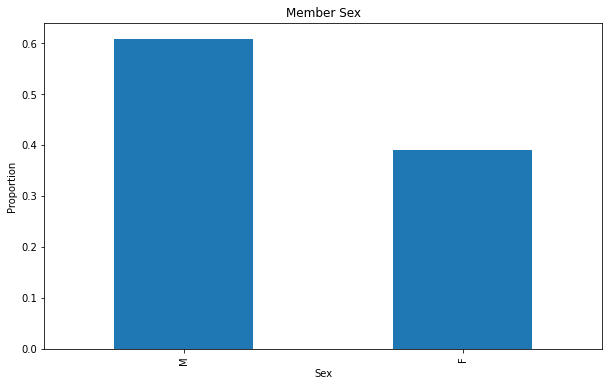

In [18]:
#plot data in matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

member_sex_props.plot(kind="bar")

ax.set_xlabel("Sex")
ax.set_ylabel("Proportion")
ax.set_title("Member Sex")
plt.gcf().set_size_inches(10, 6)

plt.show()

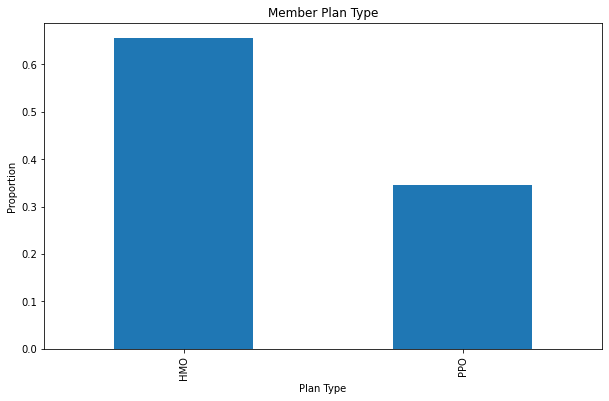

In [19]:
fig, ax = plt.subplots()

members_type_of_policy = members["Product"].value_counts(normalize=True)
members_type_of_policy.plot(kind="bar")

ax.set_xlabel("Plan Type")
ax.set_ylabel("Proportion")
ax.set_title("Member Plan Type")
plt.gcf().set_size_inches(10, 6)

plt.show()

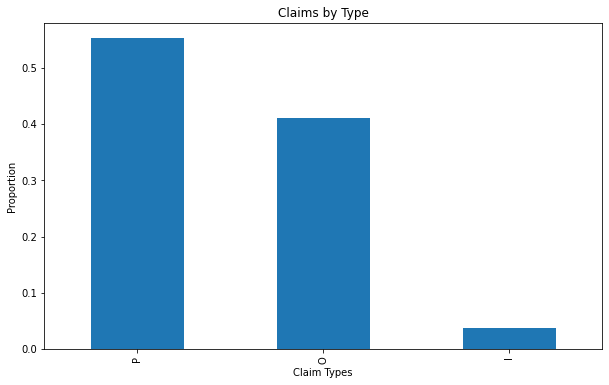

In [20]:
fig, ax = plt.subplots()

claims_by_type = claims["ClaimType"].value_counts(normalize=True)
claims_by_type.plot(kind="bar")

ax.set_xlabel("Claim Types")
ax.set_ylabel("Proportion")
ax.set_title("Claims by Type")
plt.gcf().set_size_inches(10, 6)
plt.savefig("./images/image1.png", transparent=False)
plt.show()

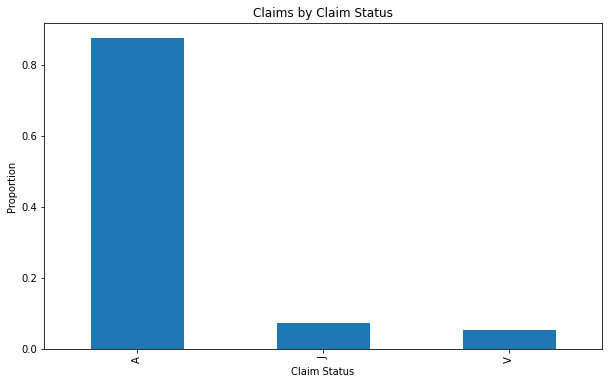

In [21]:
fig, ax = plt.subplots()

claims_by_status = claims["ClaimStatusCd"].value_counts(normalize=True)
claims_by_status.plot(kind="bar")

ax.set_xlabel("Claim Status")
ax.set_ylabel("Proportion")
ax.set_title("Claims by Claim Status")
plt.gcf().set_size_inches(10, 6)
plt.savefig("./images/image2.png", transparent=False)
plt.show()

#### **Observations:**

- The data is broken up into 60% male, 40% female.
- The member plan types are 65% HMO and 35% PPO.  
- It's worth noting these distributions were created after de-identifying the dataset.
- Most claims are Professional or outpatient, with around 5% being inpatient claims.

## Time Series Analysis:

### Initial Plot:

Let's try to visualize the number of claims, and charges based on `ServiceDate`.

In [22]:
claims.head()

,IDNO,ClaimID,ClaimLineNum,ClaimStatusCd,ClaimType,MemberID,ProviderID,posID,ServiceDate,LoadDate,Code_Type,Code_Value,Cases,Services,AllowedCharges,PaidClaims,MemberPaid,OPL
0,1,1,1,A,P,102,1664,5,2015-01-02,2015-02-28,HCPC,98941,1.0,1.0,28.0,0.0,28.0,0.0
1,2,1,2,A,P,102,1664,5,2015-01-02,2015-02-28,HCPC,97110,1.0,1.0,21.6,0.0,21.6,0.0
2,3,1,3,A,P,102,1664,5,2015-01-02,2015-02-28,HCPC,97012,0.0,1.0,12.0,0.0,12.0,0.0
3,4,1,4,A,P,102,1664,5,2015-01-02,2015-02-28,HCPC,97014,0.0,1.0,12.0,0.0,12.0,0.0
4,5,2,1,A,P,102,1664,5,2015-01-23,2015-03-14,HCPC,98941,1.0,1.0,28.0,0.0,28.0,0.0


In [23]:
#get only service date and charges
claims_ts = claims.loc[claims["ClaimStatusCd"]=="A", ["ServiceDate", "AllowedCharges", "PaidClaims", "MemberPaid"]]
claims_ts.head()

,ServiceDate,AllowedCharges,PaidClaims,MemberPaid
0,2015-01-02,28.0,0.0,28.0
1,2015-01-02,21.6,0.0,21.6
2,2015-01-02,12.0,0.0,12.0
3,2015-01-02,12.0,0.0,12.0
4,2015-01-23,28.0,0.0,28.0


In [24]:
daily_claims = claims_ts.groupby("ServiceDate").sum()
daily_claims.head()

,AllowedCharges,PaidClaims,MemberPaid
ServiceDate,,,
2015-01-01,492.72,258.90,233.82
2015-01-02,2350.11,1927.49,422.62
2015-01-03,452.42,275.99,176.43
2015-01-04,440.16,284.28,155.88
2015-01-05,45129.76,37279.60,7850.16


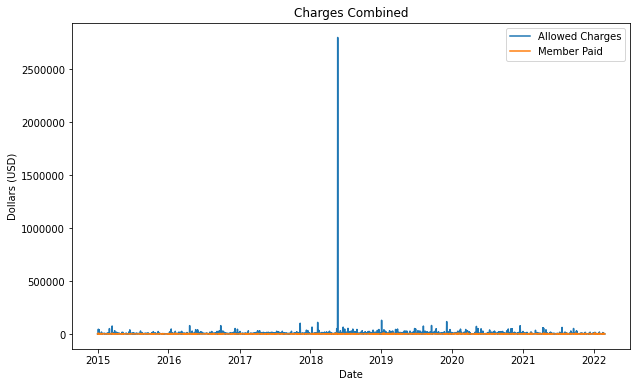

In [25]:
#time graph of AllowedCharges
fig, ax = plt.subplots()
ax.plot(daily_claims.index, daily_claims.AllowedCharges, label="Allowed Charges")
ax.plot(daily_claims.index, daily_claims.MemberPaid, label="Member Paid")

#customize appearance
plt.ticklabel_format(style='plain', axis="y")
plt.xlabel("Date")
plt.title("Charges Combined")
plt.ylabel("Dollars (USD)")
plt.gcf().set_size_inches(10, 6)
plt.legend()
plt.show()

### Outlier Analysis:

Let's investigate the spike in mid-2018 more.  First, let's find all dates that reach above 1M USD:

In [26]:
daily_claims[daily_claims["AllowedCharges"] > 1000000]

,AllowedCharges,PaidClaims,MemberPaid
ServiceDate,,,
2018-05-21,2800578.68,2799430.13,1148.55


The only date is May 21st, 2018.  Let's look at the days before and after this spike:

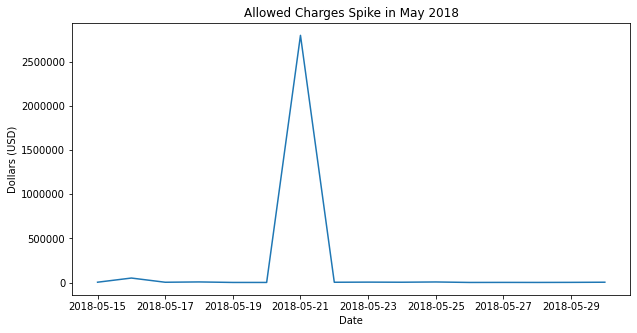

In [27]:
daily_claims_sub = daily_claims.loc[(daily_claims.index > '2018-05-14') & (daily_claims.index < '2018-05-31')]

#time graph of AllowedCharges
fig, ax = plt.subplots()
ax.plot(daily_claims_sub.index, daily_claims_sub.AllowedCharges)

#customize appearance
plt.ticklabel_format(style='plain', axis="y")
plt.xlabel("Date")
plt.title("Allowed Charges Spike in May 2018")
plt.ylabel("Dollars (USD)")
#plt.ylim([0,100000])
plt.gcf().set_size_inches(10, 5)
plt.show()

As a final check, let's calculate the mean values `AllowedCharges` without May 21st, 2018:

In [28]:
import numpy as np

np.mean(daily_claims.loc[(daily_claims.index != '2018-05-21')], axis=0)

AllowedCharges    5801.089988
PaidClaims        4594.491915
MemberPaid        1193.662165
dtype: float64

**Observations:**
- **FIXME:  Checking reason for spike.**
- For the time being, we'll remove this timepoint to improve the accuracy of our time series predictions.

In [29]:
#remove outlier from may 21st 2018
daily_claims = daily_claims[daily_claims.index != '2018-05-21']

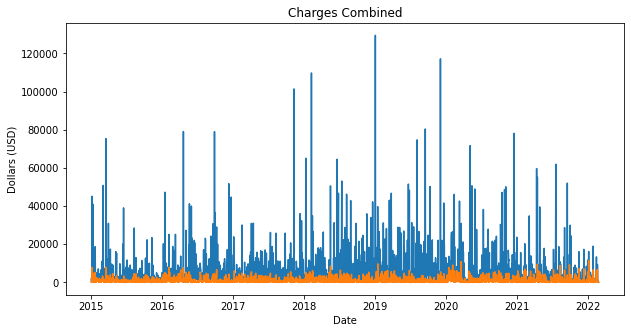

In [30]:
#time graph of AllowedCharges
fig, ax = plt.subplots()
ax.plot(daily_claims.index, daily_claims.AllowedCharges)
ax.plot(daily_claims.index, daily_claims.MemberPaid)

#customize appearance
plt.ticklabel_format(style='plain', axis="y")
plt.xlabel("Date")
plt.title("Charges Combined")
plt.ylabel("Dollars (USD)")
#plt.ylim([0,100000])
plt.gcf().set_size_inches(10, 5)
plt.show()

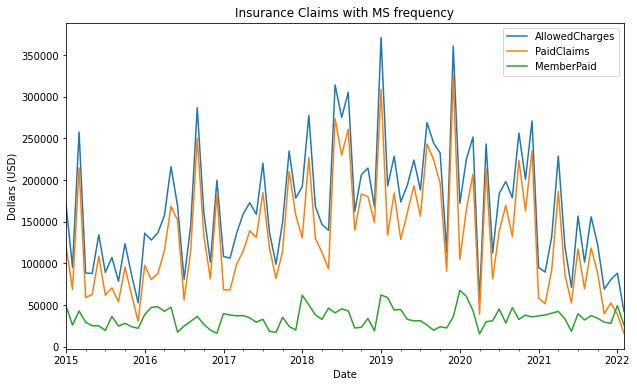

In [31]:
monthly_claims = daily_claims.groupby(pd.Grouper(freq="MS")).sum()
monthly_claims["AllowedCharges"].plot()
monthly_claims["PaidClaims"].plot()
monthly_claims["MemberPaid"].plot()

#cusotmize appearance
plt.ticklabel_format(style='plain', axis="y")
plt.title("Insurance Claims with MS frequency")
plt.xlabel("Date")
plt.ylabel("Dollars (USD)")
plt.gcf().set_size_inches(10, 6)
plt.legend()
plt.show()

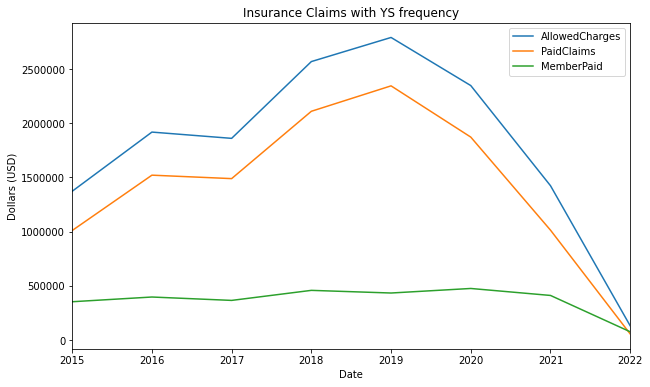

In [45]:
yearly_claims = daily_claims.groupby(pd.Grouper(freq="YS")).sum()
yearly_claims["AllowedCharges"].plot()
yearly_claims["PaidClaims"].plot()
yearly_claims["MemberPaid"].plot()

#cusotmize appearance
plt.ticklabel_format(style='plain', axis="y")
plt.title("Insurance Claims with YS frequency")
plt.xlabel("Date")
plt.ylabel("Dollars (USD)")
plt.gcf().set_size_inches(10, 6)
plt.legend()
plt.show()

### Rolling Averages

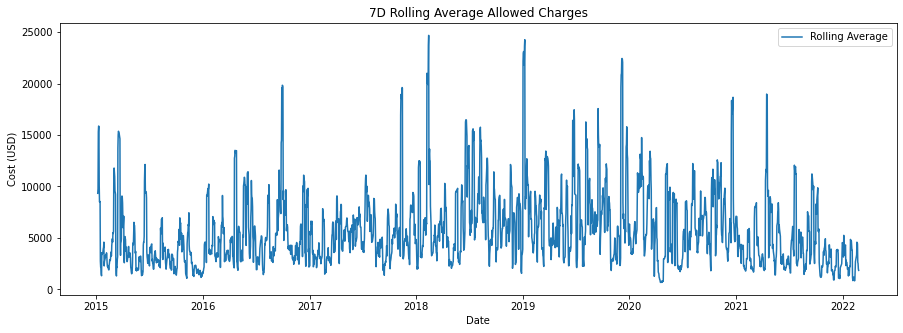

In [32]:
import seaborn as sns

daily_claims['7D_AllowedCharges'] = daily_claims.AllowedCharges.rolling(7).mean()
daily_claims['7D_MemberPaid'] = daily_claims.MemberPaid.rolling(7).mean()
daily_claims['7D_PaidClaims'] = daily_claims.PaidClaims.rolling(7).mean()

sns.lineplot(x=daily_claims.index, y='7D_AllowedCharges', data=daily_claims, label='Rolling Average')

#customize appearance
plt.title("7D Rolling Average Allowed Charges")
plt.ylabel("Cost (USD)")
plt.xlabel("Date")
plt.gcf().set_size_inches(15, 5)
plt.show()

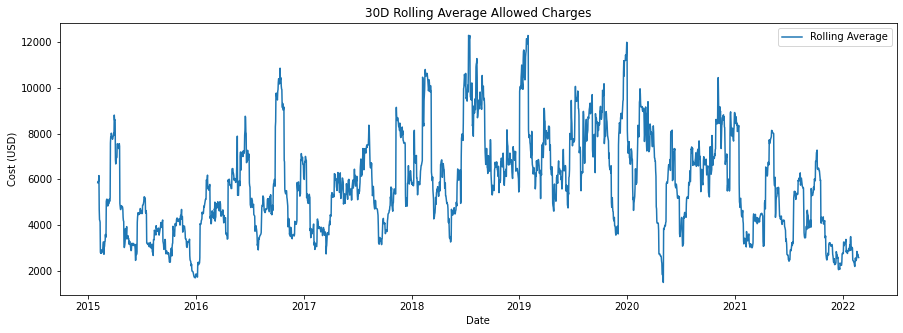

In [33]:
daily_claims['30D_AllowedCharges'] = daily_claims.AllowedCharges.rolling(30).mean()
daily_claims['30D_MemberPaid'] = daily_claims.MemberPaid.rolling(30).mean()
daily_claims['30D_PaidClaims'] = daily_claims.PaidClaims.rolling(30).mean()


sns.lineplot(x=daily_claims.index, y='30D_AllowedCharges', data=daily_claims, label='Rolling Average')

#customize appearance
plt.title("30D Rolling Average Allowed Charges")
plt.xlabel("Date")
plt.ylabel("Cost (USD)")
plt.gcf().set_size_inches(15, 5)
plt.show()

### Different Claim Types

In [34]:
claims.head()

,IDNO,ClaimID,ClaimLineNum,ClaimStatusCd,ClaimType,MemberID,ProviderID,posID,ServiceDate,LoadDate,Code_Type,Code_Value,Cases,Services,AllowedCharges,PaidClaims,MemberPaid,OPL
0,1,1,1,A,P,102,1664,5,2015-01-02,2015-02-28,HCPC,98941,1.0,1.0,28.0,0.0,28.0,0.0
1,2,1,2,A,P,102,1664,5,2015-01-02,2015-02-28,HCPC,97110,1.0,1.0,21.6,0.0,21.6,0.0
2,3,1,3,A,P,102,1664,5,2015-01-02,2015-02-28,HCPC,97012,0.0,1.0,12.0,0.0,12.0,0.0
3,4,1,4,A,P,102,1664,5,2015-01-02,2015-02-28,HCPC,97014,0.0,1.0,12.0,0.0,12.0,0.0
4,5,2,1,A,P,102,1664,5,2015-01-23,2015-03-14,HCPC,98941,1.0,1.0,28.0,0.0,28.0,0.0


In [35]:
#get unique claim types
claims.ClaimType.unique()

array(['P', 'O', 'I'], dtype=object)

In [36]:
#get only dates and allowedcharges for each claim type
P_claims = claims.loc[claims["ClaimType"] == "P", ["ServiceDate", "AllowedCharges"]]
O_claims = claims.loc[claims["ClaimType"] == "O", ["ServiceDate", "AllowedCharges"]]
I_claims = claims.loc[claims["ClaimType"] == "I", ["ServiceDate", "AllowedCharges"]]

In [37]:
#group by daily totals for each claim type
daily_P_claims = P_claims.groupby("ServiceDate").sum()
daily_O_claims = O_claims.groupby("ServiceDate").sum()
daily_I_claims = I_claims.groupby("ServiceDate").sum()

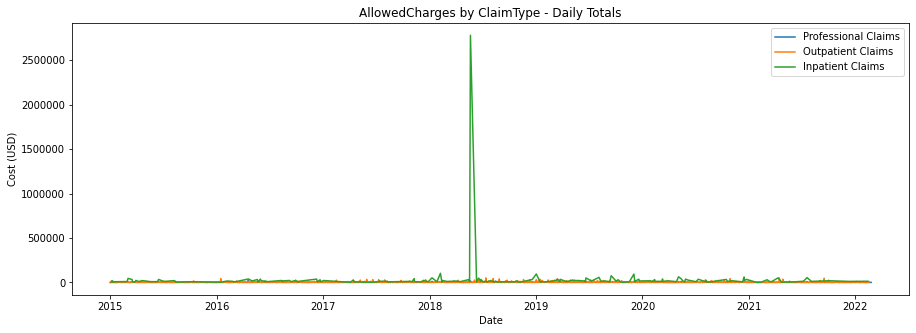

In [38]:
sns.lineplot(x=daily_P_claims.index, y='AllowedCharges', data=daily_P_claims, label='Professional Claims')
sns.lineplot(x=daily_O_claims.index, y='AllowedCharges', data=daily_O_claims, label='Outpatient Claims')
sns.lineplot(x=daily_I_claims.index, y='AllowedCharges', data=daily_I_claims, label='Inpatient Claims')

#customize appearance
plt.title("AllowedCharges by ClaimType - Daily Totals")
plt.xlabel("Date")
plt.ylabel("Cost (USD)")
plt.ticklabel_format(style='plain', axis="y")
plt.gcf().set_size_inches(15, 5)
plt.show()

**Observations:**

- The spike in May 2018 is from one inpatient claim.
- We'll look at professional and outpatient claims for the time being:

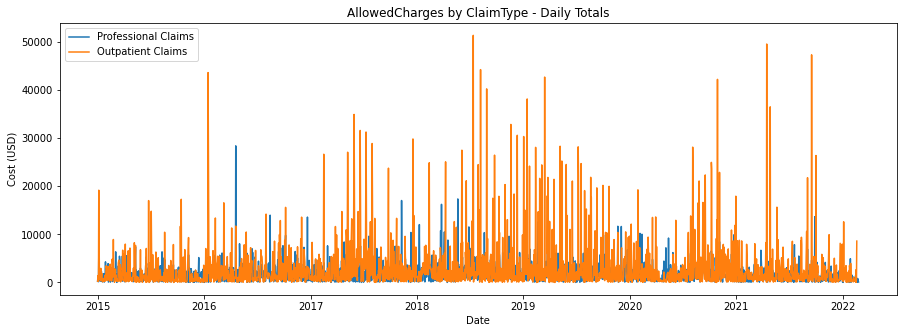

In [39]:
sns.lineplot(x=daily_P_claims.index, y='AllowedCharges', data=daily_P_claims, label='Professional Claims')
sns.lineplot(x=daily_O_claims.index, y='AllowedCharges', data=daily_O_claims, label='Outpatient Claims')

#customize appearance
plt.title("AllowedCharges by ClaimType - Daily Totals")
plt.xlabel("Date")
plt.ylabel("Cost (USD)")
plt.ticklabel_format(style='plain', axis="y")
plt.gcf().set_size_inches(15, 5)
plt.show()

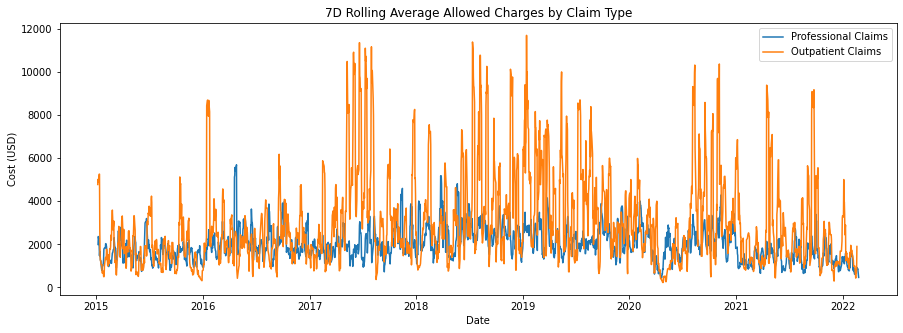

In [40]:
daily_P_claims['7D_AllowedCharges'] = daily_P_claims.AllowedCharges.rolling(7).mean()
daily_O_claims['7D_AllowedCharges'] = daily_O_claims.AllowedCharges.rolling(7).mean()
daily_I_claims['7D_AllowedCharges'] = daily_I_claims.AllowedCharges.rolling(7).mean()

sns.lineplot(x=daily_P_claims.index, y='7D_AllowedCharges', data=daily_P_claims, label='Professional Claims')
sns.lineplot(x=daily_O_claims.index, y='7D_AllowedCharges', data=daily_O_claims, label='Outpatient Claims')

#customize appearance
plt.title("7D Rolling Average Allowed Charges by Claim Type")
plt.ylabel("Cost (USD)")
plt.xlabel("Date")
plt.gcf().set_size_inches(15, 5)
plt.show()

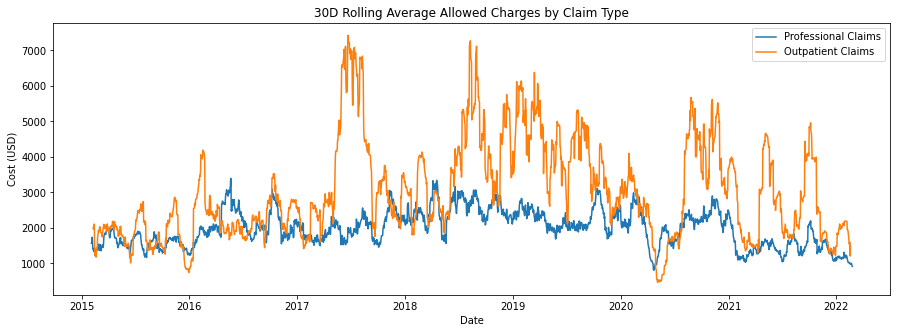

In [41]:
daily_P_claims['30D_AllowedCharges'] = daily_P_claims.AllowedCharges.rolling(30).mean()
daily_O_claims['30D_AllowedCharges'] = daily_O_claims.AllowedCharges.rolling(30).mean()
daily_I_claims['30D_AllowedCharges'] = daily_I_claims.AllowedCharges.rolling(30).mean()

sns.lineplot(x=daily_P_claims.index, y='30D_AllowedCharges', data=daily_P_claims, label='Professional Claims')
sns.lineplot(x=daily_O_claims.index, y='30D_AllowedCharges', data=daily_O_claims, label='Outpatient Claims')

#customize appearance
plt.title("30D Rolling Average Allowed Charges by Claim Type")
plt.ylabel("Cost (USD)")
plt.xlabel("Date")
plt.gcf().set_size_inches(15, 5)
plt.show()

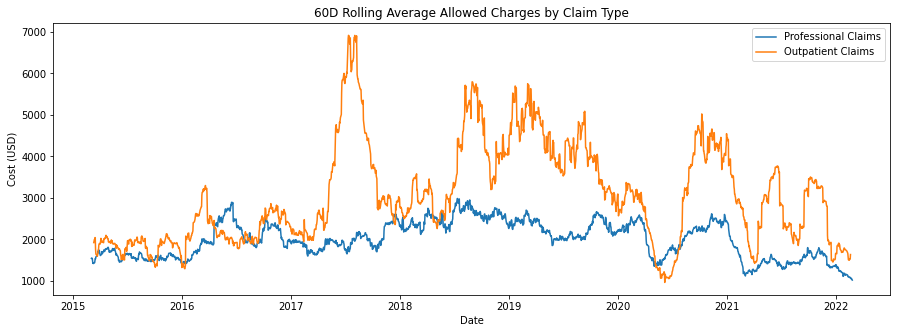

In [42]:
daily_P_claims['60D_AllowedCharges'] = daily_P_claims.AllowedCharges.rolling(60).mean()
daily_O_claims['60D_AllowedCharges'] = daily_O_claims.AllowedCharges.rolling(60).mean()
daily_I_claims['60D_AllowedCharges'] = daily_I_claims.AllowedCharges.rolling(60).mean()

sns.lineplot(x=daily_P_claims.index, y='60D_AllowedCharges', data=daily_P_claims, label='Professional Claims')
sns.lineplot(x=daily_O_claims.index, y='60D_AllowedCharges', data=daily_O_claims, label='Outpatient Claims')
#sns.lineplot(x=daily_I_claims.index, y='60D_AllowedCharges', data=daily_I_claims, label='Outpatient Claims')

#customize appearance
plt.title("60D Rolling Average Allowed Charges by Claim Type")
plt.ylabel("Cost (USD)")
plt.xlabel("Date")
plt.gcf().set_size_inches(15, 5)
plt.show()

### Predictions:

First we need to export our `monthly_claims` data.  We'll be using 2021's data for testing:

In [60]:
# Create Training and Test
train = monthly_claims[["AllowedCharges"]][:72] #includes first 72 months, aka the 6 years of training data
test = monthly_claims[["AllowedCharges"]][72:-2] #-2 because the dataset includes two months of 2022, which we will not be using

# export
train.to_csv("./data/train.csv", header=False)
test.to_csv("./data/test.csv", header=False)

#### ADF Test

In [71]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(monthly_claims["AllowedCharges"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.642407
p-value: 0.461004


#### Order of Differencing (d)

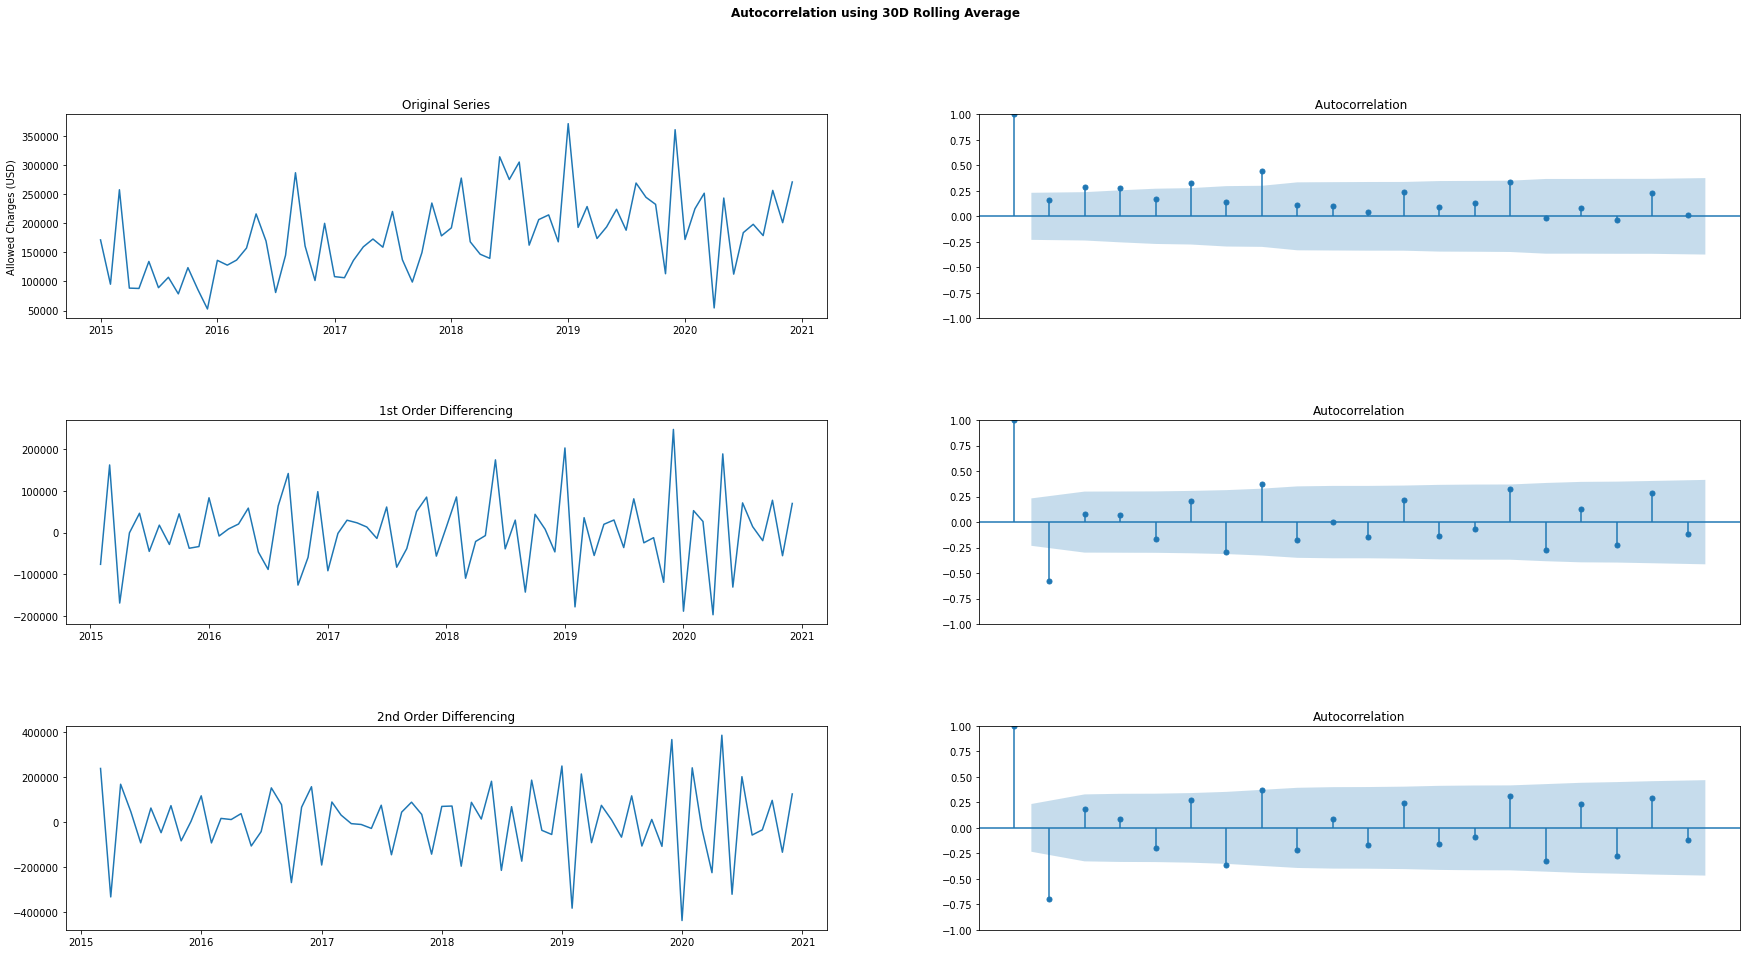

In [72]:
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(3, 2)

#create plot
axes[0, 0].plot(train["AllowedCharges"]); axes[0, 0].set_title('Original Series')
plot_acf(train["AllowedCharges"], ax=axes[0, 1], title=" Autocorrelation");
axes[1, 0].plot(train["AllowedCharges"].diff().dropna()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(train["AllowedCharges"].diff().dropna(), ax=axes[1, 1], title="Autocorrelation");
axes[2, 0].plot(train["AllowedCharges"].diff().diff().dropna()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train["AllowedCharges"].diff().diff().dropna(), ax=axes[2, 1], title="Autocorrelation");

#visuals
fig.suptitle('Autocorrelation using 30D Rolling Average', weight='bold')
axes[0,0].set_ylabel("Allowed Charges (USD)")
axes[1,0].set_ylabel("")
axes[2,0].set_ylabel("")
axes[0,1].set_xticks([])
axes[1,1].set_xticks([])
axes[2,1].set_xticks([])
plt.gcf().set_size_inches(30, 15)
plt.subplots_adjust(hspace=.5)
plt.show()

**Observations:**
- The p-value of the ADF test is 0.461 and we fail to reject the null hypothesis, the time series is non-stationary.
- 1st order differencing created a stationary time series with a constant mean and variance using a lag of 1 (i.e. .diff()).
- Additional differencing was attempted (i.e 2nd order differencing), however it did not improve the autocorrelation (see lag multiples of 3).
- **Order of differencing is 1**

#### AR term (p):

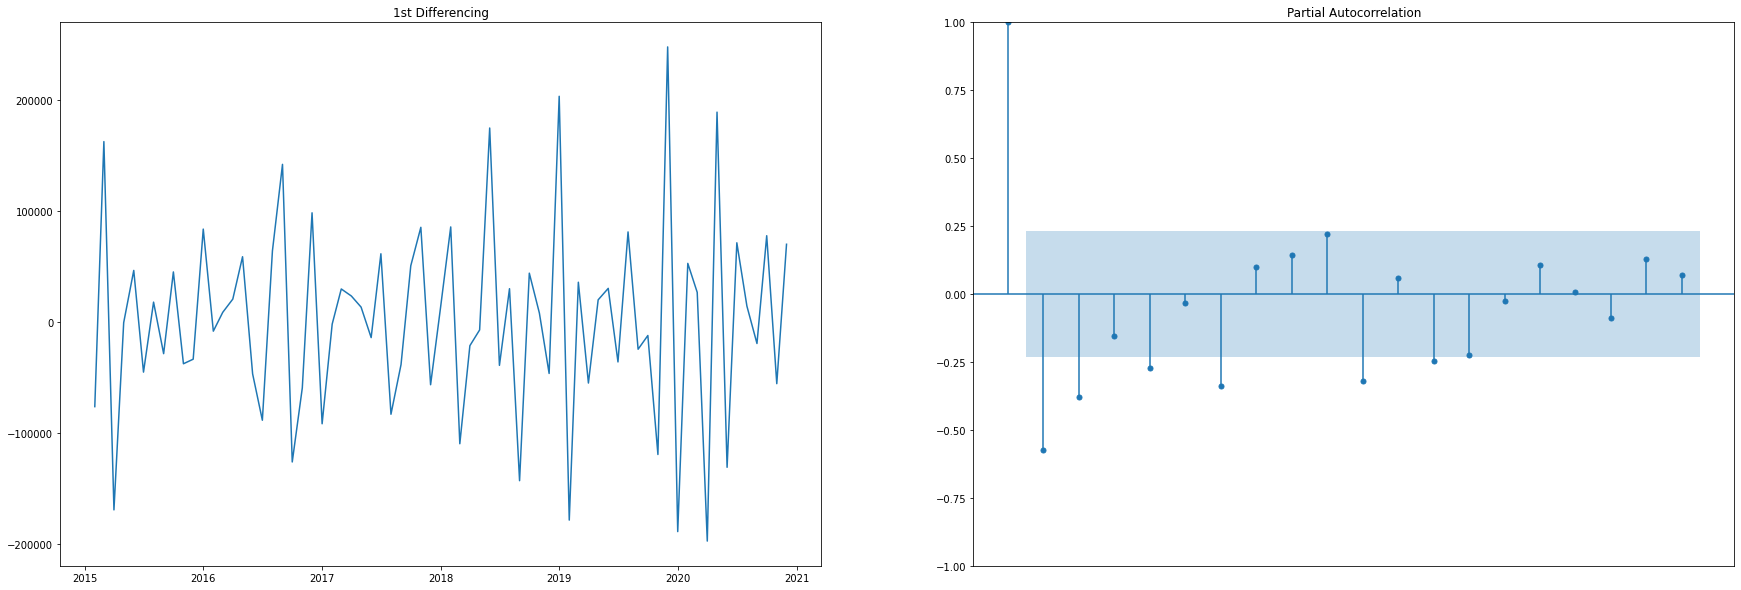

In [76]:
from statsmodels.graphics.tsaplots import plot_pacf

#create figures
fig, axes = plt.subplots(1, 2)
axes[0].plot(train["AllowedCharges"].diff()); axes[0].set_title('1st Differencing')
plot_pacf(train["AllowedCharges"].diff().dropna(), method="ywm", ax=axes[1])

#visuals
plt.gcf().set_size_inches(30, 10)
plt.xticks([])
plt.show()

**Observations:**
    
- There appear to be some lags significantly different than zero. (See lag 5, 7, 11)
- However, we will be conservative and **set the lag to 2 or 3**, depending on the outcome of predictions.

#### MA term (q):

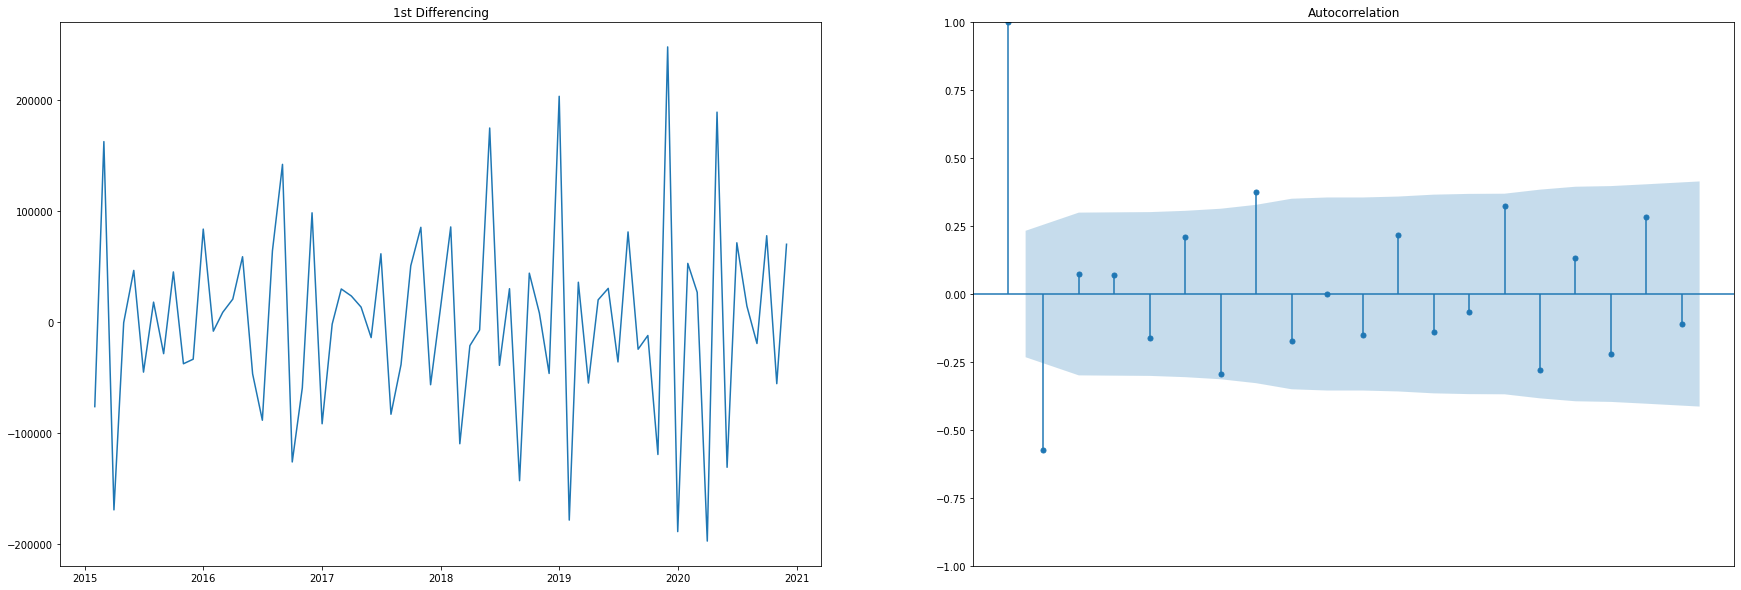

In [77]:
fig, axes = plt.subplots(1, 2)

axes[0].plot(train["AllowedCharges"].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(train["AllowedCharges"].diff().dropna(), ax=axes[1])
plt.gcf().set_size_inches(30, 10)
axes[1].set_xticks([])
plt.show()

**Observations:**

- One of the lags is above the blue region by a large amount, so we'll set the lag to 2.
- We'll build the ARIMA model using: (2, 1, 2)

In [125]:
from statsmodels.tsa.arima.model import ARIMA

# order=(p, d, q)
model = ARIMA(train["AllowedCharges"], order=(2, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         AllowedCharges   No. Observations:                   72
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -886.097
Date:                Mon, 14 Mar 2022   AIC                           1782.194
Time:                        13:10:20   BIC                           1793.508
Sample:                    01-01-2015   HQIC                          1786.693
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2923      4.562     -0.064      0.949      -9.234       8.649
ar.L2          0.0029      0.771      0.004      0.997      -1.509       1.515
ma.L1         -0.6991      4.563     -0.153      0.8

C:\Python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [126]:
from sklearn.metrics import mean_squared_error

#Import the test data, format as an array
validation = pd.read_csv('./data/test.csv', header=None, index_col=0, parse_dates=True).squeeze("columns")
y = validation.values.astype('float32')

#Import the training data, format as an array
dataset = pd.read_csv('./data/train.csv', header=None, index_col=0, parse_dates=True).squeeze("columns")
X = dataset.values.astype('float32')

history = [x for x in X] #Create a list of all training data
months_in_year = 12
predictions=list()
yhat = float(model_fit.forecast()[0])
yhat = inverse_difference(history, yhat, months_in_year)
predictions.append(y[0])
history.append(y[0])
print(f'Predicted: {yhat:.3f}, Expected: {y[0]:.3f}') #output first month's performance

#loop through all months and calculate performance
for i in range(1, len(y)):
    months_in_year = 12
    diff = difference(history, months_in_year) #account for seasonality
    model = ARIMA(diff, order=(2, 1,2)) #create ARIMA model
    model_fit = model.fit() #fit model
    yhat = model_fit.forecast()[0] #get prediction value
    yhat = inverse_difference(history, yhat, months_in_year) #reverse the difference to get value
    predictions.append(yhat) #add predicted value to list
    # observation
    obs = y[i]
    history.append(obs)
    print('Predicted: %.3f, Expected: %.3f' % (yhat, obs))

#calculate performance
rmse = np.sqrt(mean_squared_error(y, predictions))
print('\nRMSE: %.3f' % rmse)

Predicted: 372894.583, Expected: 95176.641
Predicted: 235027.513, Expected: 89546.938
Predicted: 203512.684, Expected: 132148.375


C:\Python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted: 42888.059, Expected: 228801.891
Predicted: 184024.953, Expected: 120607.398
Predicted: 57035.013, Expected: 71142.023
Predicted: 205011.470, Expected: 156872.375
Predicted: 112823.313, Expected: 101463.391
Predicted: 190437.762, Expected: 155920.172
Predicted: 184038.342, Expected: 122365.250
Predicted: 184369.225, Expected: 69112.000
Predicted: 211766.531, Expected: 80546.570

RMSE: 92640.240


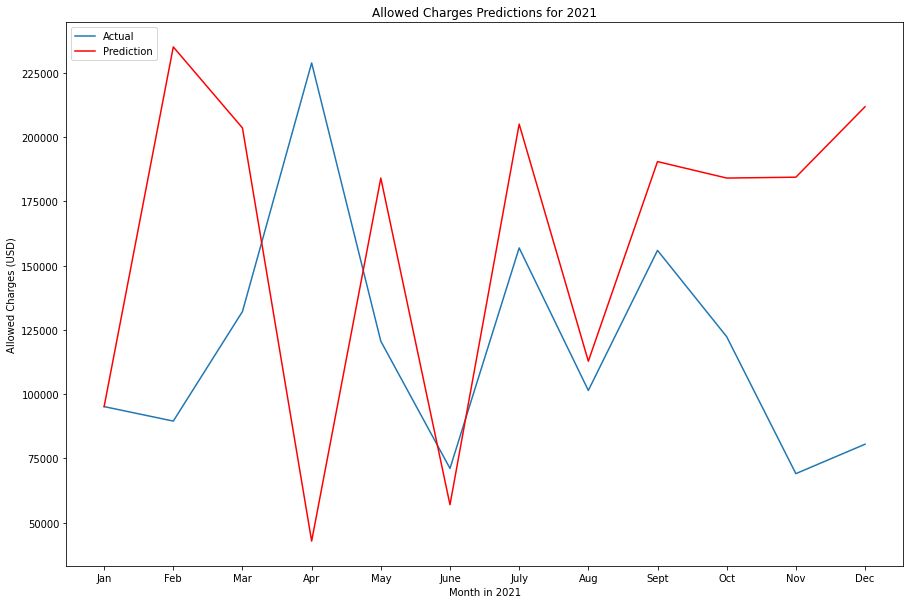

In [127]:
#plot actual versus forecast
plt.plot(y, label="Actual")
plt.plot(predictions, color='red', label="Prediction")

#visuals
plt.title("Allowed Charges Predictions for 2021")
plt.xlabel("Month in 2021")
plt.xticks(ticks=np.arange(0,12,1), labels=["Jan", "Feb", "Mar", "Apr", "May", "June", 
                                            "July", "Aug", "Sept", "Oct", "Nov", "Dec"])
plt.ylabel("Allowed Charges (USD)")
plt.gcf().set_size_inches(15, 10)
plt.legend(loc="upper left")
plt.show()